In [1]:
import numpy as np
import sys, pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Dense

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as VGG19_preprocess
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as InceotionV3_preprocess
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input as ResNet50V2_preprocess
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input as InceptionResNetV2_preprocess

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
#image_dim = int(sys.argv[1])#224, 299, 331, ...

image_dim = 384


dpath_original = 'D:kvasir_cls/kvasir-dataset-v2'
dpath_preprocess = dpath_original+'_preprocess'
class_list = ['esophagitis', 'dyed-lifted-polyps', 'dyed-resection-margins', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']

In [3]:
with open(dpath_preprocess +'/kvasir_cls_'+str(image_dim)+'no_polyp'+'.pickle', 'rb') as f:
    [X,Y] = pickle.load(f)
    print(X.shape, Y.shape)

with open(dpath_preprocess +'/kvasir_cls_'+str(image_dim)+'polyp' + '.pickle', 'rb') as w:
    [X_polyp, Y_polyp] =  pickle.load(w)
    print(X_polyp.shape, Y_polyp.shape)

assert np.max(X) == 255
assert np.min(X) == 0
assert np.max(X_polyp) == 255
assert np.min(X_polyp) == 0

(7000, 384, 384, 3) (7000, 1)
(1000, 384, 384, 3) (1000, 1)


In [19]:

# rest dataset split
X_trnval_no, X_tst_no, Y_trnval_no, Y_tst_no = train_test_split(X, Y, test_size = 1.5 / 10, random_state = 27407, stratify = Y)
X_trn_no, X_val_no, Y_trn_no, Y_val_no = train_test_split(X_trnval_no, Y_trnval_no, test_size = 1.5 / 8.5, random_state = 27407, stratify = Y_trnval_no)

# polyp split
X_trnval_polyp, X_tst_polyp, Y_trnval_polyp, Y_tst_polyp = train_test_split(X_polyp, Y_polyp, test_size = 1.5 / 10, random_state = 27407)
X_trn_polyp, X_val_polyp, Y_trn_polyp, Y_val_polyp = train_test_split(X_trnval_polyp, Y_trnval_polyp, test_size = 1.5 / 8.5, random_state = 27407)

# concatenation and onehot encoding
enc = OneHotEncoder(sparse=False)

X_trn = np.concatenate((X_trn_no, X_trn_polyp), axis=0)
Y_trn = np.concatenate((Y_trn_no, Y_trn_polyp))
Y_trn = enc.fit_transform(Y_trn)

n_class = Y_trn.shape[1]
print("total class number: ", n_class)

X_val = np.concatenate((X_val_no, X_val_polyp), axis=0)
Y_val = np.concatenate((Y_val_no, Y_val_polyp), axis=0)
Y_val = enc.fit_transform(Y_val)

X_tst = np.concatenate((X_tst_no, X_tst_polyp), axis=0)
Y_tst = np.concatenate((Y_tst_no, Y_tst_polyp), axis=0)
Y_tst = enc.fit_transform(Y_tst)


print('trn.shape', X_trn.shape, Y_trn.shape)
print('val.shape', X_val.shape, Y_val.shape)
print('tst.shape', X_tst.shape, Y_tst.shape)

total class number:  8
trn.shape (5600, 384, 384, 3) (5600, 8)
val.shape (1200, 384, 384, 3) (1200, 8)
tst.shape (1200, 384, 384, 3) (1200, 8)


In [22]:
#def preprocess_input(X): return X / 127.5 - 1  # to be in range [0,1]

BACKBONE = 'vgg16'

#preprocess_input = sm.get_preprocessing(BACKBONE)

def preprocess_output(Y): return np.asarray(Y > 0.1 * np.max(Y), dtype=np.uint8)


dataset_list = ["kvasir", "cvc", "kvasir_instrument", "ISIC2017",  ]
model_list = ["Unet", "Linknet", "FPN", "PSPNet"]

data_id = 0  # 0,1,2,3,4 (total 5 dataset)
model_id = 0  # 0, 1, 2, 3
seed_id = 4  # 10 random seed (0-9)

dataset = dataset_list[data_id]
model_name = model_list[model_id]

image_dim = 384  # to be fixed
#"D:/"+ data + '/results/'+'result_final/' + data + '_average_iou'+'.csv', header=None)

In [23]:
with open("D:/"+dataset + "/" + dataset + "_" + str(image_dim) + '.pickle', 'rb') as q:
    [X_seg, Y_seg] = pickle.load(q)
    print(X_seg.shape, Y_seg.shape)
    
Y_seg = np.expand_dims(Y_seg, 3)

assert np.max(X_seg) == 255
assert np.min(X_seg) == 0
assert np.max(Y_seg) == 1
assert np.min(Y_seg) == 0

(1000, 384, 384, 3) (1000, 384, 384)


In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
# polyp split
X_trnval_s, X_tst_s, Y_trnval_s, Y_tst_s = train_test_split(X_seg, Y_seg, test_size = 1.5 / 10, random_state = 27407)
X_trn_s, X_val_s, Y_trn_s, Y_val_s = train_test_split(X_trnval_s, Y_trnval_s, test_size = 1.5 / 8.5, random_state = 27407)


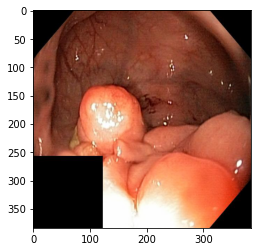

In [32]:
plt.imshow(X_trn_polyp[2])

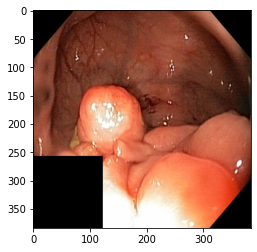

In [33]:
plt.imshow(X_trn_s[2])

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
keras.backend.set_session(tf.Session(config=config))

In [3]:
model_id = 1

In [4]:
image_dim = 384

In [5]:
with open('kvasir_cls_'+str(image_dim)+'.pickle', 'rb') as f:
    [X,Y] = pickle.load(f)
    print(X.shape, Y.shape)

(8000, 384, 384, 3) (8000, 1)


In [6]:
assert np.max(X) == 255
assert np.min(X) == 0

In [7]:
enc = OneHotEncoder(sparse=False)
Y_enc = enc.fit_transform(Y)
n_class = Y_enc.shape[1]

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [8]:
X_trnval, X_tst, Y_trnval, Y_tst = train_test_split(X, Y_enc, test_size = 1200, random_state = 27407, stratify = Y_enc)
X_trn, X_val, Y_trn, Y_val = train_test_split(X_trnval, Y_trnval, test_size = 1200, random_state = 27407, stratify = Y_trnval)

In [9]:
print('trn.shape', X_trn.shape, Y_trn.shape)
print('val.shape', X_val.shape, Y_val.shape)
print('tst.shape', X_tst.shape, Y_tst.shape)

trn.shape (5600, 384, 384, 3) (5600, 8)
val.shape (1200, 384, 384, 3) (1200, 8)
tst.shape (1200, 384, 384, 3) (1200, 8)


In [10]:
if model_id == 1: 
    base_model = VGG19(weights = 'imagenet', pooling='avg', include_top =False)
    preprocess_func = VGG19_preprocess
elif model_id == 2: 
    base_model = InceptionV3(weights = 'imagenet', pooling='avg', include_top = False)
    preprocess_func = InceptionV3_preprocess
elif model_id == 3: 
    base_model = ResNet50V2(weights = 'imagenet', pooling='avg', include_top = False)
    preprocess_func = ResNet50V2_preprocess
elif model_id == 4: 
    base_model = InceptionResNetV2(weights = 'imagenet', pooling='avg', include_top = False)
    preprocess_func = InceptionResNetV2_preprocess

In [15]:
a = []
a.append([1])

In [16]:
a

[[1]]

In [11]:
predictions = Dense(8, activation='softmax')(base_model.output)

In [12]:
model = Model(inputs = base_model.input, outputs = predictions)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [13]:
data_gen_args = dict(rotation_range = 360, width_shift_range=0.15, height_shift_range=0.15, zoom_range=0.15, 
                     brightness_range=[0.5, 1.5], horizontal_flip=True, vertical_flip=False, fill_mode='constant', cval=0)

generator = ImageDataGenerator(**data_gen_args, preprocessing_function = preprocess_func)

In [14]:
batch_size = 10

In [15]:
data_flow = generator.flow(X_trn, Y_trn, batch_size = batch_size)

In [16]:
X_val = preprocess_func(X_val)
X_tst = preprocess_func(X_tst)

In [17]:
print(':: training')
for layer in base_model.layers: layer.trainable = True
model.compile(optimizer = Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

:: training



In [18]:
earlystopper = EarlyStopping(monitor= 'val_loss', patience=20, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor= 'val_loss', factor=0.1, patience=10, min_lr = 1e-8, verbose=1)
mcp_save = ModelCheckpoint('kvasir_cls_'+str(model_id)+'.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [ ]:
model.fit_generator(data_flow, steps_per_epoch=np.ceil(len(X_trn)/batch_size), epochs=500, validation_data=(X_val, Y_val),
                   callbacks=[earlystopper, reduce_lr, mcp_save], verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/500
 - 208s - loss: 0.7231 - acc: 0.7182 - val_loss: 0.3534 - val_acc: 0.8558
Epoch 2/500


C:\Users\user\Anaconda3\lib\site-packages\keras\callbacks.py:707: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


 - 200s - loss: 0.3722 - acc: 0.8484 - val_loss: 0.3243 - val_acc: 0.8708
Epoch 3/500
 - 201s - loss: 0.3111 - acc: 0.8779 - val_loss: 0.3163 - val_acc: 0.8675
Epoch 4/500
 - 201s - loss: 0.2870 - acc: 0.8898 - val_loss: 0.2419 - val_acc: 0.9092
Epoch 5/500
 - 201s - loss: 0.2409 - acc: 0.9071 - val_loss: 0.2869 - val_acc: 0.8950
Epoch 6/500
 - 201s - loss: 0.2423 - acc: 0.9054 - val_loss: 0.3030 - val_acc: 0.8808
Epoch 7/500
 - 201s - loss: 0.2327 - acc: 0.9080 - val_loss: 0.2217 - val_acc: 0.9050
Epoch 8/500
 - 201s - loss: 0.2142 - acc: 0.9152 - val_loss: 0.2258 - val_acc: 0.9125
Epoch 9/500
 - 200s - loss: 0.2041 - acc: 0.9193 - val_loss: 0.2810 - val_acc: 0.9075
Epoch 10/500
 - 200s - loss: 0.1889 - acc: 0.9275 - val_loss: 0.2604 - val_acc: 0.9067
Epoch 11/500
 - 200s - loss: 0.1942 - acc: 0.9239 - val_loss: 0.2417 - val_acc: 0.9142
Epoch 12/500
 - 200s - loss: 0.1773 - acc: 0.9316 - val_loss: 0.2288 - val_acc: 0.9092
Epoch 13/500
 - 200s - loss: 0.1751 - acc: 0.9377 - val_loss: 0